In [57]:
!pip install yfinance
!pip install GetOldTweets3
!pip install treeinterpreter

In [0]:
import datetime
import GetOldTweets3 as got
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
import sys
import re
import string
import json
import os

In [59]:
import nltk
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
sentiment_i_a = SentimentIntensityAnalyzer()

from nltk.corpus import subjectivity
from nltk.sentiment.util import *

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
from sklearn.model_selection import train_test_split
from treeinterpreter import treeinterpreter as ti
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import svm
from sklearn.svm import SVR 

from sklearn.metrics import mean_squared_error
from math import sqrt


In [0]:
# Get hourly stock data
def getHourlyStocks(stockname):
  company = yf.Ticker(stockname)
  stockdata = company.history(interval="60m")
  stockdata.to_csv('stockData_' + stockname +'.csv')

In [0]:
# process stock data to get date and time separately
def processStockData(stockname):
  stockdata = pd.read_csv('stockData_' + stockname +'.csv',encoding='utf-8')
  stockdata.head()

  temp = str(stockdata['Datetime'].values)
  new = temp.split("\n")
  temp1 = ' '.join(str(new).split())
  temp1 = temp1.replace('"', '')
  temp1 = temp1.replace('\'', '')
  temp1 = temp1.replace(',', '')
  temp1 = temp1.replace('[', '')
  temp1 = temp1.replace(']', '')
  temp1 = temp1.replace('-04:00', '')
  new2 = temp1.split(" ")
  new2 = [x.strip() for x in new2 if x.strip()]

  indx = 0
  for i in range(0,len(new2),2):
    stockdata.at[indx,'date'] = new2[i]
    indx = indx + 1

  indx = 0
  for j in range(1,len(new2),2):
    stockdata.at[indx,'time'] = new2[j]
    indx = indx + 1

  stockdata = stockdata.drop('Datetime', 1)
  stockdata['time'] = stockdata['time'].apply(lambda x: datetime.datetime.strptime(x,'%H:%M:%S').time())
  stockdata.head()
  stockdata.to_csv('processedStockData_' + stockname +'.csv')
  startDate = stockdata['date'].iloc[0]
  endDate = stockdata['date'].iloc[len(stockdata)-1]
  return startDate, endDate

In [0]:
#Method for data cleaning
class TweetCleaner:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.punc_table = str.maketrans("", "", string.punctuation) # to remove punctuation from each word in tokenize

    def compound_word_split(self, compound_word):
        matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', compound_word)
        return [m.group(0) for m in matches]

    def remove_non_ascii_chars(self, text):
        return ''.join([w if ord(w) < 128 else ' ' for w in text])

    def remove_hyperlinks(self,text):
        return ' '.join([w for w in text.split(' ')  if not 'http' in w])

    def get_cleaned_text(self, text):
        cleaned_tweet = text.replace('\"','').replace('\'','').replace('-',' ')
        cleaned_tweet =  self.remove_non_ascii_chars(cleaned_tweet)
        if re.match(r'RT @[_A-Za-z0-9]+:',cleaned_tweet):
            cleaned_tweet = cleaned_tweet[cleaned_tweet.index(':')+2:]
        cleaned_tweet = self.remove_hyperlinks(cleaned_tweet)
        cleaned_tweet = cleaned_tweet.replace('#','HASHTAGSYMBOL').replace('@','ATSYMBOL') # to avoid being removed while removing punctuations
        tokens = [w.translate(self.punc_table) for w in word_tokenize(cleaned_tweet)] # remove punctuations and tokenize
        tokens = [nltk.WordNetLemmatizer().lemmatize(w) for w in tokens if not w.lower() in self.stop_words and len(w)>1] # remove stopwords and single length words
        cleaned_tweet = ' '.join(tokens)
        cleaned_tweet = cleaned_tweet.replace('HASHTAGSYMBOL','#').replace('ATSYMBOL','@')
        cleaned_tweet = cleaned_tweet
        return cleaned_tweet

    def clean_tweets(self, tweets, is_bytes = False):   
        test_tweet_list = []
        for tweet in tweets:
            if is_bytes:
                test_tweet_list.append(self.get_cleaned_text(ast.literal_eval(tweet).decode("UTF-8")))
            else:
                test_tweet_list.append(self.get_cleaned_text(tweet))
        return test_tweet_list
    
    def clean_single_tweet(self, tweet, is_bytes = False):  
        if is_bytes:
             return self.get_cleaned_text(ast.literal_eval(tweet).decode("UTF-8"))
        return self.get_cleaned_text(tweet)
    
    def cleaned_file_creator(self, op_file_name, value1, value2):
        csvFile = open(op_file_name, 'w+')
        csvWriter = csv.writer(csvFile)
        for tweet in range(len(value1)):
            csvWriter.writerow([value1[tweet], value2[tweet]])
        csvFile.close()

In [0]:
#fetch tweet data
def fetchTweets(stockname, startDate, endDate):
  csvFile = open('tweets_' + stockname + '.csv', 'a',encoding="utf-8")
  csvWriter = csv.writer(csvFile, lineterminator= '\n')
  cleanObj = TweetCleaner()
  
  tweetCriteria = got.manager.TweetCriteria().setQuerySearch(stockname).setSince(startDate).setUntil(endDate).setTopTweets("true") 
  tweets = got.manager.TweetManager.getTweets(tweetCriteria)
  try:
    for tweet in tweets:
      tweet_text = tweet.text.encode('utf-8')
      tweet_text = cleanObj.get_cleaned_text(tweet_text.decode())
      tweetDate = tweet.date
      csvWriter.writerow([tweetDate, tweet.text])
  except BaseException as e:
      print('failed on_status,',str(e))


In [0]:
# process tweet data to get date and time separately
def processTweetData(stockname):
  columns=['Date','Tweets']
  tweets = pd.read_csv('tweets_' + stockname + '.csv',encoding='utf-8', names=columns, header=None)

  temp = str(tweets['Date'].values)
  new = temp.split("\n")
  temp1 = ' '.join(str(new).split())
  temp1 = temp1.replace('"', '')
  temp1 = temp1.replace('\'', '')
  temp1 = temp1.replace(',', '')
  temp1 = temp1.replace('[', '')
  temp1 = temp1.replace(']', '')
  temp1 = temp1.replace('+00:00', '')
  new2 = temp1.split(" ")
  new2 = [x.strip() for x in new2 if x.strip()]

  indx = 0
  for i in range(0,len(new2),2):
    tweets.at[indx,'date'] = new2[i]
    indx = indx + 1

  indx = 0
  for j in range(1,len(new2),2):
    tweets.at[indx,'time'] = new2[j]
    indx = indx + 1

  tweets = tweets.drop('Date', 1)
  tweets.head()
  tweets.to_csv('processedTweets_' + stockname + '.csv')

In [0]:
# process both stock and tweet data to get prices for respective date and time
def processData(stockname):
  date_time_obj1 = datetime.datetime.strptime('09:30:00', '%H:%M:%S').time()
  date_time_obj2 = datetime.datetime.strptime('10:30:00', '%H:%M:%S').time()
  date_time_obj3 = datetime.datetime.strptime('11:30:00', '%H:%M:%S').time()
  date_time_obj4 = datetime.datetime.strptime('12:30:00', '%H:%M:%S').time()
  date_time_obj5 = datetime.datetime.strptime('13:30:00', '%H:%M:%S').time()
  date_time_obj6 = datetime.datetime.strptime('14:30:00', '%H:%M:%S').time()
  date_time_obj7 = datetime.datetime.strptime('15:30:00', '%H:%M:%S').time()

  column_names = ["date", "time", "Tweets"]
  df = pd.DataFrame(columns = column_names)

  tweets = pd.read_csv('processedTweets_' + stockname + '.csv',encoding='utf-8')
  tweets['time'] = tweets['time'].apply(lambda x: datetime.datetime.strptime(x,'%H:%M:%S').time())
  
  readStockData = pd.read_csv('processedStockData_' + stockname +'.csv')

  indx1 = 0 
  indx2 = 1
  indx3 = 2 
  indx4 = 3
  indx5 = 4 
  indx6 = 5

  get_tweet1 = ""
  get_tweet2 = ""
  get_tweet3 = ""
  get_tweet4 = ""
  get_tweet5 = ""
  get_tweet6 = ""

  # mapping hourly tweets
  for i in range(0,len(tweets)-1):
    get_date= tweets.date.iloc[i]
    next_date= tweets.date.iloc[i+1]
    if(str(get_date)==str(next_date)):
      # check time
      if tweets.time.iloc[i] > date_time_obj1 and tweets.time.iloc[i] < date_time_obj2:
        get_tweet1 = get_tweet1 + tweets.Tweets.iloc[i] + " "

      if tweets.time.iloc[i] > date_time_obj2 and tweets.time.iloc[i] < date_time_obj3:
        get_tweet2 = get_tweet2 + tweets.Tweets.iloc[i] + " "

      if tweets.time.iloc[i] > date_time_obj3 and tweets.time.iloc[i] < date_time_obj4:
        get_tweet3 = get_tweet3 + tweets.Tweets.iloc[i] + " "

      if tweets.time.iloc[i] > date_time_obj4 and tweets.time.iloc[i] < date_time_obj5:
        get_tweet4 = get_tweet4 + tweets.Tweets.iloc[i] + " "

      if tweets.time.iloc[i] > date_time_obj5 and tweets.time.iloc[i] < date_time_obj6:
        get_tweet5 = get_tweet5 + tweets.Tweets.iloc[i] + " "

      if tweets.time.iloc[i] > date_time_obj6 and tweets.time.iloc[i] < date_time_obj7:
        get_tweet6 = get_tweet6 + tweets.Tweets.iloc[i] + " "
    
    if(str(get_date)!=str(next_date)):
      df.at[indx1,'date'] = get_date
      df.at[indx1,'time'] = date_time_obj2
      df.at[indx1,'Tweets'] = get_tweet1

      df.at[indx2,'date'] = get_date
      df.at[indx2,'time'] = date_time_obj3
      df.at[indx2,'Tweets'] = get_tweet2

      df.at[indx3,'date'] = get_date
      df.at[indx3,'time'] = date_time_obj4
      df.at[indx3,'Tweets'] = get_tweet3

      df.at[indx4,'date'] = get_date
      df.at[indx4,'time'] = date_time_obj5
      df.at[indx4,'Tweets'] = get_tweet4

      df.at[indx5,'date'] = get_date
      df.at[indx5,'time'] = date_time_obj6
      df.at[indx5,'Tweets'] = get_tweet5

      df.at[indx6,'date'] = get_date
      df.at[indx6,'time'] = date_time_obj7
      df.at[indx6,'Tweets'] = get_tweet6

      indx1 = indx1 + 6
      indx2 = indx2 + 6
      indx3 = indx3 + 6
      indx4 = indx4 + 6
      indx5 = indx5 + 6
      indx6 = indx6 + 6

      get_tweet1 = ""
      get_tweet2 = ""
      get_tweet3 = ""
      get_tweet4 = ""
      get_tweet5 = ""
      get_tweet6 = ""

  # drop rows if tweets are not present
  df['Tweets'].replace('', np.nan, inplace=True)
  df.dropna(subset=['Tweets'], inplace=True)
  df.reset_index(drop=True, inplace=True)
  df.head()

  # map prices for respective date and time
  df['Prices']=""
  for i in range (0,len(df)):
    for j in range (0,len(readStockData)):
      get_tweet_date = df.date.iloc[i]
      get_tweet_time = df.time.iloc[i]

      get_stock_date = readStockData.date.iloc[j]
      get_stock_time = readStockData.time.iloc[j]

      if(str(get_stock_date)==str(get_tweet_date)):
        if(str(get_tweet_time) == str(get_stock_time)):
          df.at[i,'Prices'] = int(readStockData.Close[j])
          break

  # dropping rows if prices are not available
  df['Prices'].replace('', np.nan, inplace=True)
  df.dropna(subset=['Prices'], inplace=True)
  df.reset_index(drop=True, inplace=True)
  df['Prices'] = df['Prices'].apply(np.int64)        
  df.to_csv('processedData_' + stockname +'.csv')

In [0]:
# performing sentiment analysis
def sentimentAnalysis(stockname):
  df = pd.read_csv('processedData_' + stockname +'.csv')
  df["Comp"] = ''
  df["Negative"] = ''
  df["Neutral"] = ''
  df["Positive"] = ''
  for indexx, row in df.T.iteritems():
    try:
      sentence_i = unicodedata.normalize('NFKD', df.loc[indexx, 'Tweets'])
      sentence_sentiment = sentiment_i_a.polarity_scores(sentence_i)
      df.at[indexx, 'Comp'] =  sentence_sentiment['compound']
      df.at[indexx, 'Negative'] = sentence_sentiment['neg']
      df.at[indexx, 'Neutral'] =  sentence_sentiment['neu']
      df.at[indexx, 'Positive'] = sentence_sentiment['pos'] 
    except TypeError:
      print('failed on_status,',str(e))

  print(df.head())
  df.to_csv('sentimentAnalysis_' + stockname +'.csv')
  posi=0
  nega=0
  neutral = 0
  for i in range (0,len(df)):
    get_val=df.Comp[i]
    if(float(get_val)<(0)):
        nega=nega+1
    if(float(get_val>(0))):
        posi=posi+1
    if(float(get_val)==(0)):
        neutral=neutral+1

  posper=(posi/(len(df)))*100
  negper=(nega/(len(df)))*100
  neutralper=(neutral/(len(df)))*100

  print("% of positive tweets= ",posper)
  print("% of negative tweets= ",negper)
  print("% of neutral tweets= ",neutralper)

  arr=np.asarray([posper,negper,neutralper], dtype=int)
  plt.figure()
  plt.pie(arr,labels=['positive','negative', 'neutral'])
  plt.plot()

In [0]:
# Predicting stock prices using Random Forest model
def RandomForestModel(stockname):
  df = pd.read_csv('sentimentAnalysis_' + stockname +'.csv')
  train, test = train_test_split(df, shuffle=False, test_size=0.2)
  print(train.size)
  print(test.size)

  sentiment_score_list_train = []
  for date, row in train.T.iteritems():
    sentiment_score = np.asarray([df.loc[date, 'Negative'], df.loc[date, 'Neutral'],  df.loc[date, 'Positive']])
    sentiment_score_list_train.append(sentiment_score)
  numpy_df_train = np.asarray(sentiment_score_list_train)

  sentiment_score_list_test = []
  for date, row in test.T.iteritems():
    sentiment_score = np.asarray([df.loc[date, 'Negative'], df.loc[date, 'Neutral'], df.loc[date, 'Positive']])
    sentiment_score_list_test.append(sentiment_score)
  numpy_df_test = np.asarray(sentiment_score_list_test)

  y_train = pd.DataFrame(train['Prices'])
  y_test = pd.DataFrame(test['Prices'])

  rf = RandomForestRegressor()
  rf.fit(numpy_df_train, y_train)
  prediction, bias, contributions = ti.predict(rf, numpy_df_test)

  print("\n\n")
  plt.figure()
  plt.plot(test['Prices'].iloc[:].values)
  plt.plot(prediction.flatten())
  plt.title('Random Forest predicted prices')
  plt.ylabel('Stock Prices')
  plt.xlabel('Days')
  plt.legend(['actual', 'predicted'])
  plt.show()

  print("\n\n")
  print("RMSE value for Random Forest Model : ")
  rmse = sqrt(mean_squared_error(y_test, prediction.flatten()))
  print(rmse)
  print("\n\n")


In [0]:
# Predicting stock prices using Support Vector Regression model
def SVRModel(stockname):
  df = pd.read_csv('sentimentAnalysis_' + stockname +'.csv')
  train, test = train_test_split(df, shuffle=False, test_size=0.2)
  print(train.size)
  print(test.size)

  sentiment_score_list_train = []
  for date, row in train.T.iteritems():
    sentiment_score = np.asarray([df.loc[date, 'Negative'], df.loc[date, 'Neutral'],  df.loc[date, 'Positive']])
    sentiment_score_list_train.append(sentiment_score)
  numpy_df_train = np.asarray(sentiment_score_list_train)

  sentiment_score_list_test = []
  for date, row in test.T.iteritems():
    sentiment_score = np.asarray([df.loc[date, 'Negative'], df.loc[date, 'Neutral'], df.loc[date, 'Positive']])
    sentiment_score_list_test.append(sentiment_score)
  numpy_df_test = np.asarray(sentiment_score_list_test)

  y_train = pd.DataFrame(train['Prices'])
  y_test = pd.DataFrame(test['Prices'])

  svr_rbf = SVR(kernel='rbf', C=1e6, gamma=0.1)
  svr_rbf.fit(numpy_df_train, y_train.values.flatten())
  output_test_svm = svr_rbf.predict(numpy_df_test)

  plt.figure()
  plt.plot(test['Prices'].iloc[:].values)
  plt.plot(output_test_svm)
  plt.title('SVM predicted prices')
  plt.ylabel('Stock Prices')
  plt.xlabel('Days')
  plt.legend(['actual', 'predicted'])
  plt.show()

  print("\n\n")
  print("RMSE value for Support Vector Regression Model : ")
  rmse = sqrt(mean_squared_error(y_test, output_test_svm))
  print(rmse)
  print("\n\n")

Enter a valid STOCKNAME of the Corporation: 
------------------------------ Getting Stock details and processing it -----------------------------
Stock Details fetched! 

------------------------------ Fetching Tweets and processing it-----------------------------
Tweets fetched! 

------------- Process data by fetching Tweets and prices for respective date and hour ----------------------
Completed Data Processing! 

------------------------------ Sentiment analysis of tweets on hourly basis-----------------------------
   Unnamed: 0        date      time  ... Negative  Neutral Positive
0           0  2020-04-30  14:30:00  ...        0        1        0
1           1  2020-04-29  15:30:00  ...        0        1        0
2           2  2020-04-30  11:30:00  ...        0        1        0
3           3  2020-04-30  14:30:00  ...    0.159     0.53    0.311
4           4  2020-04-27  14:30:00  ...        0    0.838    0.162

[5 rows x 9 columns]
% of positive tweets=  43.54838709677419
% o

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


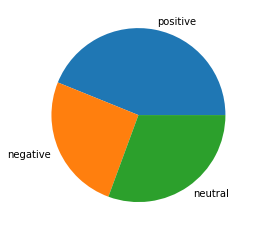

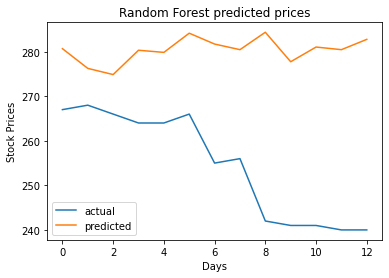




RMSE value for Random Forest Model : 
28.70300286235729



Completed Random Forest prediction! 

------------------------------ Predicting stock prices using Support Vector Regression model-----------------------------
490
130


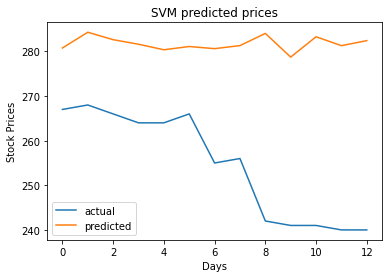




RMSE value for Support Vector Regression Model : 
29.510346059426293



Completed Support Vector Regression prediction! 



In [71]:
def main():
  name = input("Enter a valid STOCKNAME of the Corporation: ") #enter the name of the company
  if(len(name) > 0):
    STOCKNAME  = name
  else:
    STOCKNAME = "AAPL"

  #Get Stock Details and get date and time
  print("------------------------------ Getting Stock details and processing it -----------------------------")
  getHourlyStocks(STOCKNAME)
  startDate, endDate = processStockData(STOCKNAME)
  print("Stock Details fetched! \n")

  #Fetching tweets and get date and time
  print("------------------------------ Fetching Tweets and processing it-----------------------------")
  fetchTweets(STOCKNAME, startDate, endDate)
  processTweetData(STOCKNAME)
  print("Tweets fetched! \n")

  # Process data by fetching Tweets and prices for respective date and hour
  print("------------- Process data by fetching Tweets and prices for respective date and hour ----------------------")
  processData(STOCKNAME)
  print("Completed Data Processing! \n")

  # Sentiment analysis of tweets on hourly basis
  print("------------------------------ Sentiment analysis of tweets on hourly basis-----------------------------")
  sentimentAnalysis(STOCKNAME)
  print("Completed sentiment Analysis! \n")

  # Predicting stock prices using Random Forest model
  print("------------------------------ Predicting stock prices using Random Forest model-----------------------------")
  RandomForestModel(STOCKNAME)
  print("Completed Random Forest prediction! \n")

  # Predicting stock prices using Support Vector Regression model
  print("------------------------------ Predicting stock prices using Support Vector Regression model-----------------------------")
  SVRModel(STOCKNAME)
  print("Completed Support Vector Regression prediction! \n")

main()